In [57]:
from PIL import Image
import pandas as pd
from glob import glob
from random import randint
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,filename,left,top,right,bottom,company_name,full_name,position_name,address,phone_number,fax,mobile,email,url
0,2842.png,491,455,796,485,0,0,0,0,0,0,1,0,0
1,182.png,24,858,311,886,0,0,0,0,0,0,1,0,0
2,95.png,320,498,865,521,0,0,0,0,0,1,1,0,0
3,2491.png,65,39,497,118,1,0,0,0,0,0,0,0,0
4,3301.png,271,83,333,463,0,1,1,0,0,0,0,0,0


In [4]:
train_images1 = glob(".\\train_images_1\\train_images_1\\*.png")
train_images2 = glob(".\\train_images_2\\train_images_2\\*.png")
train_images3 = glob(".\\train_images_3\\train_images_3\\*.png")

In [5]:
train_images = train_images1 + train_images2 + train_images3

In [6]:
assert len(train_images) == df_train['filename'].nunique()

------

## Read Business card and bounding box

In [34]:
def showRandomBusinessCardWithLabels(df:pd.DataFrame,images:list):
    randomImagePath = images[randint(0,len(images))]
    randomImageName = randomImagePath.split("\\")[-1]
    businessCardImageObj = Image.open(randomImagePath).convert('RGB')
    businessCardCVImage = np.array(businessCardImageObj)
    businessCardCVImage = businessCardCVImage[:, :, ::-1].copy()
    df[df['filename']==randomImageName]
    for i in range(df_train[df_train['filename']==randomImageName].shape[0]):
        left = df_train[df_train['filename']==randomImageName].iloc[i]['left']
        top = df_train[df_train['filename']==randomImageName].iloc[i]['top']
        right = df_train[df_train['filename']==randomImageName].iloc[i]['right']
        bottom = df_train[df_train['filename']==randomImageName].iloc[i]['bottom']
        label_dict = dict(df_train[df_train['filename']==randomImageName].iloc[i][5:])
        label = max(label_dict, key=label_dict.get)

        COLORS = (np.random.randint(10,255), np.random.randint(10,255), np.random.randint(10,255))
        businessCardCVImage_rects = cv.rectangle(businessCardCVImage,(left,top),(right,bottom),color=COLORS,thickness=3)
        businessCardCVImage_rects = cv.putText(businessCardCVImage_rects, label, ((right+left)//2, top), cv.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
   
    plt.imshow(businessCardCVImage_rects,aspect='auto')
    plt.axis('off')
    plt.show()

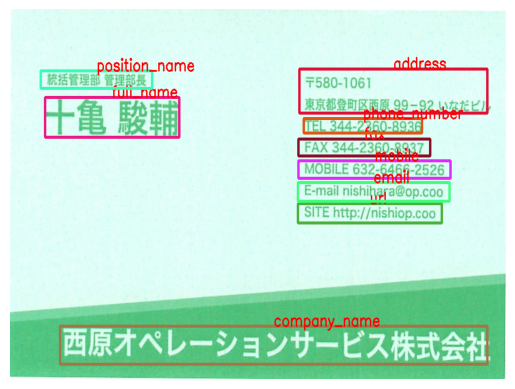

In [37]:
showRandomBusinessCardWithLabels(df_train,train_images)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train,val = train_test_split(train_images,test_size=0.1,random_state=42,shuffle=True)

In [11]:
print("Train Size: {} and Validation Size: {}".format(len(train),len(val)))

Train Size: 2556 and Validation Size: 284


In [30]:
labels_index_dict = {label:index for index,label in enumerate(list(df_train.columns[5:]))}

In [77]:
def prepareDataset(imgPaths,df:pd.DataFrame,type='train'):
    eachBusinessCard = df.groupby(by='filename')
    image_annotations_dict = {}
    for trainPath in tqdm(imgPaths):
        annotations = []
        
        #Copy the file to train or val folder depending on type
        shutil.copy(trainPath,'.\\data\\images\\{}\\'.format(type))

        fileName = trainPath.split("\\")[-1]
        df = eachBusinessCard.get_group(fileName)
        im = cv.imread(trainPath)
        im_height = im.shape[0]
        im_width = im.shape[1]
        for i in range(df.shape[0]):
            #label_bbox = {}
            left = df.iloc[i]['left']
            top = df.iloc[i]['top']
            right = df.iloc[i]['right']
            bottom = df.iloc[i]['bottom']
            label_dict = dict(df.iloc[i][5:])
            label = max(label_dict, key=label_dict.get)
            index = labels_index_dict[label]
            xcen = float((left + right)) / 2 / im_width
            ycen = float((bottom + top)) / 2 / im_height

            w = float(right - left)/im_width
            h = float(bottom - top)/im_height

            #label_bbox[index] = [xcen,ycen,w,h]
            annotations.append([index,xcen,ycen,w,h])

        annotations = np.array(annotations)
        np.savetxt(".\\data\\labels\\{}\\{}.txt".format(type,fileName[:-4]),annotations,fmt=["%d","%f","%f","%f","%f"])


        image_annotations_dict[fileName] = annotations

    #return image_annotations_dict

In [79]:
prepareDataset(train,df_train,type='train')
prepareDataset(val,df_train,type='val')

100%|██████████| 284/284 [00:06<00:00, 43.14it/s]


In [ ]:
# Train Model Command
!python train.py --img 512 --batch 2 --data jpBusinessCard_cfg.yaml --cfg models/yolov5s.yaml --epochs 100 --name detectJapaneseBusinessCardLabels

In [ ]:
!python detect.py --weights .\\runs\\train\\readJapaneseBusinessCard\\weights\\best.pt --source ..\\test_images\\test_images --img 512 --conf 0.6 --iou-thres 0.5 --save-txt --name results